<a href="https://colab.research.google.com/github/AanchalA/WeekendProjects/blob/main/Pytorch_Stable_Diffusion_VAE_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import math
import torch
import shutil
import torchvision
from torch import nn
from tqdm.auto import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.nn import functional as F
from huggingface_hub import snapshot_download
from sklearn.model_selection import train_test_split
from diffusers import AutoencoderKL, StableDiffusionPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [2]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


# Self Attention

In [3]:
class SelfAttention(nn.Module):
    def __init__(self, n_heads, embedding_dimensions, in_projection_bias=True, out_projection_bias=True):
        """
        Multi-head Self-Attention module.
        Args:
            n_heads (int): Number of attention heads.
            embedding_dimensions (int): Dimensionality of input embeddings.
            in_projection_bias (bool, optional): If True, includes a bias term in input projections. Defaults to True.
            out_projection_bias (bool, optional): If True, includes a bias term in output projection. Defaults to True.
        """
        super().__init__()
        assert embedding_dimensions % n_heads == 0, "Embedding dimensions must be divisible by number of heads."

        self.n_heads = n_heads
        self.embedding_dimensions = embedding_dimensions
        self.d_heads = embedding_dimensions // n_heads

        # Combined projection for Q, K, V
        self.in_projection = nn.Linear(in_features=embedding_dimensions,
                                       out_features=3 * embedding_dimensions,
                                       bias=in_projection_bias)

        self.out_projection = nn.Linear(in_features=embedding_dimensions,
                                        out_features=embedding_dimensions,
                                        bias=out_projection_bias)


    def forward(self, x, causal_mask=False):
        """
        Forward pass for self-attention.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, embedding_dimensions).
            causal_mask (bool, optional): If True, applies a causal mask to prevent attention to future tokens. Defaults to False.
        Returns:
            torch.Tensor: Output tensor after self-attention of shape (batch_size, seq_len, embedding_dimensions).
        """

        batch_size, seq_len, embed_dim = x.shape     ## seq_len = image_height * image_width
        assert embed_dim == self.embedding_dimensions, "Input embedding dimension mismatch."

        # Project input to Q, K, V
        qkv = self.in_projection(x)  # Shape: (batch_size, seq_len, 3 * embedding_dimensions)
        # Splitting in_projections into Q, K, V
        q, k, v = qkv.chunk(3, dim=-1)  # Each: (batch_size, seq_len, embedding_dimensions)

        # Reshape and transpose Q, K, V for multi-head attention to allow parallel computation across heads.
        # (batch_size, seq_len, embedding_dimensions) -->
        # --> (batch_size, seq_len, n_heads, d_heads) -->
        # --> (batch_size, n_heads, seq_len, d_head)
        interim_shape = (batch_size, seq_len, self.n_heads, self.d_heads)
        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        ## Compute scaled dot-product atttention scores
        # (batch_size, n_heads, seq_len, d_head) * (batch_size, n_heads, d_head, seq_len)
        # = (batch_size, n_heads, seq_len, seq_len)
        atttention_scores = torch.matmul(q, k.transpose(-1, -2))
        atttention_scores /= math.sqrt(self.d_heads)

        if causal_mask:
            # Create a causal mask to prevent attention to future tokens
            # mask where the upper triangle above the principle diagonal in 1
            mask = torch.triu(torch.ones_like(atttention_scores, device=x.device), diagonal=1).bool()
            # Fill the upper triangle with -inf
            atttention_scores = atttention_scores.masked_fill(mask.unsqueeze(0).unsqueeze(0), float('-inf'))

        # Apply softmax to get attention weights
        atttention_weights = torch.softmax(atttention_scores, dim=-1)  # (batch_size, n_heads, seq_len, seq_len)

        # Contextulazied embeddings: Apply attention weights to values
        output = atttention_scores @ v      # (batch_size, n_heads, seq_len, d_head)

        # Concatenate heads and project the output
        output = output.transpose(1, 2).contiguous()     # (batch_size, seq_len, n_heads, d_head)
        # Change the shape to the shape of out_projection
        output = output.view(batch_size, seq_len, self.embedding_dimensions)  # (batch_size, seq_len, embedding_dimensions)

        # Final linear projection
        output = self.out_projection(output)        # (batch_size, seq_len, embedding_dimensions)

        return output

# Attention Block

This attention block uses self attention using residual technique with group norms as all the features we have are pixels, and attention tries to find what are good features to pay attention in all features.

In [4]:
class AttentionBlock(nn.Module):
    def __init__(self, num_channels, num_groups=32, n_heads=1, dropout_rate=0.1,
                 in_projection_bias=True, out_projection_bias=True):
        """
        Attention block with Group Normalization and Self-Attention.
        Args:
            channels (int): Number of input channels.
            num_groups (int, optional): Number of groups for GroupNorm. Must divide channels evenly. Defaults to 32.
            n_heads (int, optional): Number of attention heads. Defaults to 1.
            in_projection_bias (bool, optional): If True, adds a bias term to the input projection layer. Defaults to True.
            out_projection_bias (bool, optional): If True, adds a bias term to the output projection layer. Defaults to True.
            dropout_rate (float, optional): Dropout probability. Defaults to 0.1.
        """
        super().__init__()

         # Ensure that the number of groups divides the number of channels
        assert num_channels % num_groups == 0, (
            f"Number of channels ({num_channels}) must be divisible by "
            f"num_groups ({num_groups}).")

        # Group Normalization for Attention Layer
        self.group_norm_1 = nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)

        # Self-Attention
        self.attention = SelfAttention(n_heads=n_heads, embedding_dimensions=num_channels,
                                       in_projection_bias=in_projection_bias,
                                       out_projection_bias=out_projection_bias)

        # Add dropout after attention
        self.dropout_1 = nn.Dropout(p=dropout_rate)

        # # Second Group Normalization for Feed-Forward Network
        # self.group_norm_2 = nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)

        # # Feed-Forward Network
        # self.feed_forward = nn.Sequential(nn.Linear(in_features=num_channels, out_features=num_channels*4),
        #                                   nn.ReLU(inplace=True),
        #                                   nn.Linear(in_features=num_channels*4, out_features=num_channels))

        # # Add dropout after the Feed-Forward Network
        # self.dropout_2 = nn.Dropout(p=dropout_rate)


    def forward(self, x):
        """
        Forward pass for the AttentionBlock.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, channels, height, width).
        """

        # For residual connection after attention
        residual = x.clone()

        # Apply Group Normalization
        x = self.group_norm_1(x)     # (B, C, H, W)

        # x: batch_size(B), num_channels(C), image_height(H), image_width(W)
        batch_size, num_channels, image_height, image_width = x.shape

        x = x.view((batch_size, num_channels, image_height * image_width))        # (B, C, H*W)
        x = x.permute(0, 2, 1)         # (B, H*W, C)

        # Apply Self-Attention without Mask
        x = self.attention(x)   # (B, H*W, C)

        # Apply Dropout after Self-Attention
        x = self.dropout_1(x)  # (B, H*W, C)

        # Reshape back to spatial dimensions
        x = x.permute(0, 2, 1).contiguous()    # (B, C, H*W)
        x = x.view((batch_size, num_channels, image_height, image_width))       # (B, C, H, W)

        # Add residual connection
        x += residual   # (B, C, H, W)

        # # Residual for feed-forward
        # residual = x

        # # Apply Group Normalization for feed-forward network
        # x = self.group_norm_2(x)  # (B, C, H, W)
        # x = x.view(batch_size, num_channels, image_height * image_width)  # (B, C, H*W)
        # x = x.permute(0, 2, 1)  # (B, H*W, C)

        # # Apply Feed-Forward Network
        # x = self.feed_forward(x)  # (B, H*W, C)

        # # Apply Dropout after the Feed-Forward Network
        # x = self.dropout_2(x)

        # # Reshape back to spatial dimensions
        # x = x.permute(0, 2, 1).contiguous()  # (B, C, H*W)
        # x = x.view(batch_size, num_channels, image_height, image_width)  # (B, C, H, W)

        # # Add residual connection
        # x += residual  # (B, C, H, W)

        return x

# ResidualBlock

This ResidualBlock will be used in Encoder and Decoder

In [5]:
class SEBlock(nn.Module):
    """
    Enhancing the residual block with SE modules can improve the network's ability to model channel-wise dependencies.
    """
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.se(x)

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups=32,
                 kernel_size=3, padding=1, stride=1):
        """
        Residual Block with Group Normalization and Convolutional Layers.
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            num_groups (int, optional): Number of groups for GroupNorm. Must divide in_channels and out_channels evenly. Defaults to 32.
            kernel_size (int, optional): Kernel size for convolutional layers. Defaults to 3.
            padding (int, optional): Padding for convolutional layers. Defaults to 1.
            stride (int, optional): Stride for convolutional layers. Defaults to 1.
        """
        super().__init__()

        # Ensure that the number of groups divides the number of channels
        assert in_channels % num_groups == 0, (
            f"Number of channels ({in_channels}) must be divisible by "
            f"num_groups ({num_groups}).")

        assert out_channels % num_groups == 0, (
            f"Number of channels ({out_channels}) must be divisible by "
            f"num_groups ({num_groups}).")

        self.group_norm_1 = nn.GroupNorm(num_groups=num_groups, num_channels=in_channels)
        self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)

        self.group_norm_2 = nn.GroupNorm(num_groups=num_groups, num_channels=out_channels)
        self.conv_2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            # the input is added directly to the output.
            self.residual_layer = nn.Identity()
        else:
            # a 1x1 convolutional layer to the input's channel dimensions to match the output for proper addition.
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

        # Initialize weights
        # self._initialize_weights()

        # Integrate SEBlock into ResidualBlock
        # self.se = SEBlock(out_channels)


    def forward(self, x):
        """
        Forward pass for the ResidualBlock.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_channels, height, width).
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_channels, height_out, width_out).
        """

        # x: (B, IN_C, H, W)

        residue = x.clone()

        x = self.group_norm_1(x)
        x = torch.selu(x)
        x = self.conv_1(x)

        x = self.group_norm_2(x)
        x = self.conv_2(x)

        # x = self.se(x)
        x += self.residual_layer(residue)

        return x

    def _initialize_weights(self):
        """
        Initializes weights of convolutional layers using Kaiming Normal initialization.
        """
        for m in self.modules():

            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.GroupNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


# Encoder Block


This Encoder Block is designed to transform input images into lower-dimensional latent representations.

Key Components:
- **Convolutional Layers:** Extract hierarchical features from the input images, capturing spatial hierarchies and patterns.
- **Residual Blocks:** Facilitate the construction of deeper networks by allowing gradients to flow more effectively, mitigating issues like vanishing gradients.

Forward Pass:
- **Feature Extraction:** The input image is passed through a series of convolutional layers and residual blocks to extract meaningful features.
- **Latent Representation:** From the extracted features, the forward method computes the mean and standard deviation.
- **Latent Vector:** These statistics are combined to generate the final latent vector, which serves as a compact representation of the input image in the latent space.


In [7]:
class Encoder(nn.Sequential):
    def __init__(self):
        """
        Encoder Block to transform input images into lower-dimensional latent representations.

        Architecture:
        - Multiple convolutional layers with residual connections for deep feature extraction.
        - Attention mechanism to capture global dependencies.
        - Group Normalization and activation functions to stabilize and introduce non-linearity.
        - Outputs latent variables using the reparameterization trick for probabilistic modeling.
        """
        super().__init__(

            # Initial Convolution:
            # (B, C=3(Colour Channels), H, W) --> (B, C=128(num kernels), H, W)
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            # --> (B, 128, H, W)
            ResidualBlock(128, 128),

            # Downsampling:
            # --> (B, 128, H / 2, W / 2)
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
            # --> (B, 256, H / 2, W / 2)
            ResidualBlock(128, 256),
            # --> (B, 256, H / 2, W / 2)
            ResidualBlock(256, 256),

            # Downsampling:
            # --> (B, 256, H / 4, W / 4)
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0),
             # --> (B, 512, H / 4, W / 4)
            ResidualBlock(256, 512),
            # --> (B, 512, H / 4, W / 4)
            ResidualBlock(512, 512),

            # Downsampling:
            # --> (B, 512, H / 8, W / 8)
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0),
            # --> (B, 512, H / 8, W / 8)
            ResidualBlock(512, 512),
            # --> (B, 512, H / 8, W / 8)
            ResidualBlock(512, 512),
            # --> (B, 512, H / 8, W / 8)
            ResidualBlock(512, 512),

            # Attention Mechanism:
            # --> (B, 512, H / 8, W / 8)
            AttentionBlock(512),

            # Residual Connection Post-Attention:
            # --> (B, 512, H / 8, W / 8)
            ResidualBlock(512, 512),

            # Group Normalization and Activation:
            # --> (B, 512, H / 8, W / 8)
            nn.GroupNorm(32, 512),
            # --> (B, 512, H / 8, W / 8)
            nn.SiLU(),

            # Final Convolutions:
            # --> (B, 8, H / 8, W / 8)
            nn.Conv2d(512, 8, kernel_size=3, padding=1),
            # --> (B, 8, H / 8, W / 8)
            nn.Conv2d(8, 8, kernel_size=1, padding=0),
        )


    def forward(self, x):
        """
        Forward pass for the Encoder.
        Args:
            x (torch.Tensor): Input tensor of shape (Batch Size, 3, Height, Width).
        Returns:
            torch.Tensor: Latent tensor 'z' of shape (Batch Size, 4, H/8, W/8).
        """
        # x: (B, C, H, W)

        # Iterate through each module in the sequential layers
        for module in self:
            if isinstance(module, nn.Conv2d) and module.stride == (2, 2):
                # Apply padding before downsampling convolutions to maintain spatial consistency
                # to ensure that the spatial dimensions are divisible by the stride, preventing issues like size mismatch during downsampling.
                x = F.pad(x, (0, 1, 0, 1))      ## (left, right, top, bottom)
            x = module(x)

        # Split x into mean and log_variance for latent variables
        # X: (B, 8, H / 8, W / 8) --> Two tensors of shape (B, 4, H / 8, W / 8)
        mean, log_variance = torch.chunk(x, 2, dim=1)

        # Clamp log variance between -30 and 20
        # Prevents extreme values in log_variance that could lead to numerical instability during training.
        log_variance = torch.clamp(log_variance, -30, 20)

        # Reparameterization Trick: z = mean + std * epsilon
        # Compute standard deviation from log_variance
        std = torch.exp(0.5 * log_variance)
        # Sample epsilon from standard normal distribution
        eps = torch.randn_like(std)

        # Compute the latent variable
        # Allows for backpropagation through stochastic sampling by expressing the latent variable x as a deterministic function of mean, std, and a random variable eps.
        x = mean + eps * std

        # Scale the latent representation
        x *= 0.18215

        return x       # (B, 4, H/8, W/8)

# Decoder Block


This Decoder Block transforms latent representations back into their original image dimensions.

Key Components:
- **Attention Block:** Enhances the decoder's ability to focus on relevant features by capturing long-range dependencies within the latent space.
- **Residual Blocks:** Facilitate the construction of deeper networks by allowing gradients to flow more effectively, mitigating issues like vanishing gradients.
- **Upsample Layer:** Increases the spatial dimensions of the feature maps, progressively restoring the image to its original size.

Forward Pass:
1. **Attention Mechanism:** Applies the attention block to the latent representations, enabling the decoder to attend to significant features.
2. **Residual Processing:** Passes the data through a series of residual blocks to refine and reconstruct detailed features.
3. **Upsampling:** Utilizes upsample layers (e.g., nearest-neighbor or transposed convolutions) to expand the feature maps' spatial dimensions, gradually rebuilding the original image size.
4. **Final Output:** Produces the reconstructed image with the same dimensions as the input, completing the decoding process.



In [8]:
class Decoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            # (B, 4, 32, 32) --> (B, 512, 32, 32)
            nn.Conv2d(4, 512, kernel_size=3, padding=1),

            # --> (B, 512, 32, 32)
            ResidualBlock(512, 512),

            # --> (B, 512, 32, 32)
            AttentionBlock(512),

            # --> (B, 512, 32, 32)
            ResidualBlock(512, 512),

            # --> (B, 512, 32, 32)
            ResidualBlock(512, 512),

            # --> (B, 512, 32, 32)
            ResidualBlock(512, 512),

            # --> (B, 512, 64, 64)
            nn.Upsample(scale_factor=2),

            # --> (B, 512, 64, 64)
            nn.Conv2d(512, 512, kernel_size=3, padding=1),

            # --> (B, 512, 64, 64)
            ResidualBlock(512, 512),

            # --> (B, 512, 64, 64)
            ResidualBlock(512, 512),

            # --> (B, 512, 64, 64)
            ResidualBlock(512, 512),

            # --> (B, 512, 128, 128)
            nn.Upsample(scale_factor=2),

             # --> (B, 512, 128, 128)
            nn.Conv2d(512, 512, kernel_size=3, padding=1),

            # --> (B, 256, 128, 128)
            ResidualBlock(512, 256),

            # --> (B, 256, 128, 128)
            ResidualBlock(256, 256),

            # --> (B, 256, 128, 128)
            ResidualBlock(256, 256),

            # --> (B, 256, 256, 256)
            nn.Upsample(scale_factor=2),

             # --> (B, 256, 256, 256)
            nn.Conv2d(256, 256, kernel_size=3, padding=1),

            # --> (B, 128, 256, 256)
            ResidualBlock(256, 128),

            # --> (B, 128, 256, 256)
            ResidualBlock(128, 128),

            # --> (B, 128, 256, 256)
            ResidualBlock(128, 128),

            # --> (B, 128, 256, 256)
            nn.GroupNorm(32, 128),

            # --> (B, 128, 256, 256)
            nn.SiLU(),

            # # --> (B, 3, 256, 256)
            nn.Conv2d(128, 3, kernel_size=3, padding=1)
        )


    def forward(self, x):
        # x: (B, 4, H/8, W/8)

        # Remove the scaling added by the encoder
        x /= 0.18215

        for module in self:
            x = module(x)

        # (B, 3, H=256, W=256)
        return x

# Variational Auto Encoder Module

In [9]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        # print(f"Input Shape: {x.shape}")
        encoded = self.encoder(x)
        # print(f"Images Encoded: {encoded.shape}")
        decoded = self.decoder(encoded)
        # print(f"X Decoded: {decoded.shape}")
        return encoded, decoded

In [10]:
summary(model=VariationalAutoEncoder(),
        input_size=(4, 3, 56, 56),               ### [batch_size, num_channels, Height, Width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
VariationalAutoEncoder (VariationalAutoEncoder)    [4, 3, 56, 56]       [4, 4, 7, 7]         --                   True
├─Encoder (encoder)                                [4, 3, 56, 56]       [4, 4, 7, 7]         --                   True
│    └─Conv2d (0)                                  [4, 3, 56, 56]       [4, 128, 56, 56]     3,584                True
│    └─ResidualBlock (1)                           [4, 128, 56, 56]     [4, 128, 56, 56]     --                   True
│    │    └─GroupNorm (group_norm_1)               [4, 128, 56, 56]     [4, 128, 56, 56]     256                  True
│    │    └─Conv2d (conv_1)                        [4, 128, 56, 56]     [4, 128, 56, 56]     147,584              True
│    │    └─GroupNorm (group_norm_2)               [4, 128, 56, 56]     [4, 128, 56, 56]     256                  True
│    │    └─Conv2d (conv_2)                

# Configurations

In [11]:
# Device Configuration
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [12]:
# Hyperparameters

batch_size = 4
num_epochs = 100
learning_rate = 1e-4
beta = 0.00025          ## KL Divergence Weight

accumulation_steps = 1  # Adjust as needed
effective_batch_size = batch_size * accumulation_steps

# Download and Process The Training Dataset

In [13]:
def split_dataset(source_dir, train_dir, test_dir, test_size=0.2, random_state=42):
    image_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    train_files, test_files = train_test_split(image_files, test_size=test_size, random_state=random_state)

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(train_dir, file))

    for file in test_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(test_dir, file))

    print(f"Dataset split complete. {len(train_files)} training images, {len(test_files)} test images.")

In [14]:
source_dir = "./all-dogs"
train_dir = "./data/train/dogs"
test_dir = "./data/test/dogs"

In [15]:
# if os.path.isdir(train_dir):
#     print(f"[INFO] {train_dir} directory exists, skipping download.")
# else:
#     print(f"[INFO] Did not find {train_dir} directory, creating one...")
#     ! gdown 1KXRTB_q4uub_XOHecpsQjE4Kmv76sZbV
#     ! unzip all-dogs.zip
#     split_dataset(source_dir, train_dir, test_dir)

Streaming output truncated to the last 5000 lines.
  inflating: all-dogs/n02107683_215.jpg  
  inflating: all-dogs/n02093428_5326.jpg  
  inflating: all-dogs/n02105412_8018.jpg  
  inflating: all-dogs/n02093647_3129.jpg  
  inflating: all-dogs/n02088466_8078.jpg  
  inflating: all-dogs/n02108915_4214.jpg  
  inflating: all-dogs/n02089078_2841.jpg  
  inflating: all-dogs/n02105855_3498.jpg  
  inflating: all-dogs/n02094114_2823.jpg  
  inflating: all-dogs/n02088094_649.jpg  
  inflating: all-dogs/n02091831_2232.jpg  
  inflating: all-dogs/n02096585_3105.jpg  
  inflating: all-dogs/n02109961_977.jpg  
  inflating: all-dogs/n02097047_5869.jpg  
  inflating: all-dogs/n02106030_16250.jpg  
  inflating: all-dogs/n02110958_13721.jpg  
  inflating: all-dogs/n02107142_8437.jpg  
  inflating: all-dogs/n02094433_1312.jpg  
  inflating: all-dogs/n02097474_5481.jpg  
  inflating: all-dogs/n02097130_1531.jpg  
  inflating: all-dogs/n02092339_284.jpg  
  inflating: all-dogs/n02093859_36.jpg  
  infla

# Data Loading and Transformation

In [16]:
transform = transforms.Compose([transforms.Resize(size=(56, 56)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                     std=[0.5, 0.5, 0.5])])

In [17]:
# dataset = torchvision.datasets.ImageFolder(root='./data/train', transform=transform)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# len(dataset), len(dataloader), len(dataset) / batch_size

# image, label = dataset[0]
# print(image.shape, label)

# Model Training

In [20]:
# model = VariationalAutoEncoder().to(device)

# loss_fn = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# train_losses = list()

# for epoch in tqdm(range(num_epochs)):
#     model.train()
#     train_loss = 0

#     for index, (images, _) in enumerate(dataloader):
#         images = images.to(device)

#         # Forward Pass
#         encoded, reconstructed = model(images)

#         # Calculate the Loss
#         reconstruction_loss = loss_fn(reconstructed, images)

#         # Extract the mean and log_variance form the encoded images
#         mean, log_variance = torch.chunk(encoded, 2, dim=1)         ## (b, `C`, h, w)

#         kl_divergence = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())
#         loss = reconstruction_loss + beta * kl_divergence

#         # Normalize the loss to account for accumulation
#         loss /= accumulation_steps

#         # Loss Backward
#         loss.backward()

#         if (index + 1) % accumulation_steps == 0:
#             optimizer.zero_grad()
#             optimizer.step()

#         train_loss += loss.item() * accumulation_steps

#         print(f'Epoch: [{epoch + 1} / {num_epochs}], Step: [{index + 1} / {len(dataloader)}] | '
#               f'Loss: {loss.item() * accumulation_steps: .4f}, '
#               f'Reconstruction Loss: {reconstruction_loss.item(): .4f}, '
#               f'KL Div: {kl_divergence.item(): .4f}')


#         model.eval()
#         with torch.inference_mode():
#             # Take the first image from the batch
#             sample_image = images[0].unsqueeze(0)
#             reconstructed_sample = model(sample_image)[1]

#             sample_image = (sample_image * 0.5) + 0.5
#             reconstructed_sample = (reconstructed_sample * 0.5) + 0.5

#             torchvision.utils.save_image(reconstructed_sample, 'reconstructed.png')

#     train_losses.append(train_loss / len(dataloader))

#     # Save the model checkpoint
#     torch.save(model.state_dict(), f'vae_model_epoch_{epoch + 1}.pth')

# print('Training Completed!')

# Plot the Loss Curve

In [ ]:
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('VAE Loss over Time')
# plt.legend()
# plt.show()

# Custom VAE

In [22]:
class CustomVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        x_reconstructed = self.decode(z)
        return x_reconstructed

    def load_pretrained_weights(self, weights_path):
        self.load_state_dict(torch.load(weights_path))

# Diffusers Compatiable VAE

In [36]:
class DiffusersVAE(AutoencoderKL):
    def __init__(self, vae):
        super().__init__()
        self.vae = vae

    def encode(self, x):
        mean, log_variance = self.vae.encoder(x)
        print(f"Mean: {mean}")
        return mean, log_variance

    def decode(self, z, **kwargs):
        print(f"Decoder Input Shape: {z.shape}")
        output = self.vae.decoder(z).unsqueeze(dim=0)
        print(f"Decoder Output Shape: {output.shape}")
        return output

In [37]:
stable_diffusion_model = "CompVis/stable-diffusion-v1-4"
model_path = "./model"

snapshot_download(stable_diffusion_model, local_dir=model_path)
AutoencoderKL.from_pretrained(f"{model_path}/vae")

Fetching 33 files:   0%|          | 0/33 [00:00<?, ?it/s]

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [29]:
# https://drive.google.com/file/d/1nNZ-xX6csIWsVmdHonS_4tM1l1-CSsPk/view?usp=sharing
! gdown 1nNZ-xX6csIWsVmdHonS_4tM1l1-CSsPk

Downloading...
From (original): https://drive.google.com/uc?id=1nNZ-xX6csIWsVmdHonS_4tM1l1-CSsPk
From (redirected): https://drive.google.com/uc?id=1nNZ-xX6csIWsVmdHonS_4tM1l1-CSsPk&confirm=t&uuid=21a5fce7-4dde-4b22-b296-a37d78c90b0d
To: /content/vae_model_epoch_21.pth
100% 315M/315M [00:01<00:00, 235MB/s]


In [32]:
# custom_vae_model_weights = torch.load("/content/vae_model_epoch_21.pth", map_location="cpu", weights_only=True)

# new_weights = {}
# for key, value in custom_vae_model_weights.items():
#     # Remove "_" from keys - "group_norm_1", "conv_1"
#     # new_key = key.replace("_", "")

#     # Add "_" in specific patterns to match "CustomVAE"
#     new_key = new_key.replace("residuallayer", "residual_layer")
#     new_key = new_key.replace("inprojection", "in_projection")
#     new_key = new_key.replace("outprojection", "out_projection")

#     new_weights[new_key] = value

In [38]:
custom_vae_model_weights = torch.load("/content/vae_model_epoch_21.pth", map_location="cpu", weights_only=True)

vae = CustomVAE()
vae.load_state_dict(custom_vae_model_weights)
vae = vae.to(device)
print(vae)

CustomVAE(
  (encoder): Encoder(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ResidualBlock(
      (group_norm_1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (conv_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (group_norm_2): GroupNorm(32, 128, eps=1e-05, affine=True)
      (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (residual_layer): Identity()
    )
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
    (3): ResidualBlock(
      (group_norm_1): GroupNorm(32, 128, eps=1e-05, affine=True)
      (conv_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (group_norm_2): GroupNorm(32, 256, eps=1e-05, affine=True)
      (conv_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (residual_layer): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (4): ResidualBlock(
      (group_norm_1): GroupNorm(32, 256,

In [39]:
compatible_vae = DiffusersVAE(vae=vae)
pipe = StableDiffusionPipeline.from_pretrained(stable_diffusion_model, vae=compatible_vae)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Decoder Input Shape: torch.Size([1, 4, 64, 64])
Decoder Output Shape: torch.Size([1, 1, 3, 512, 512])


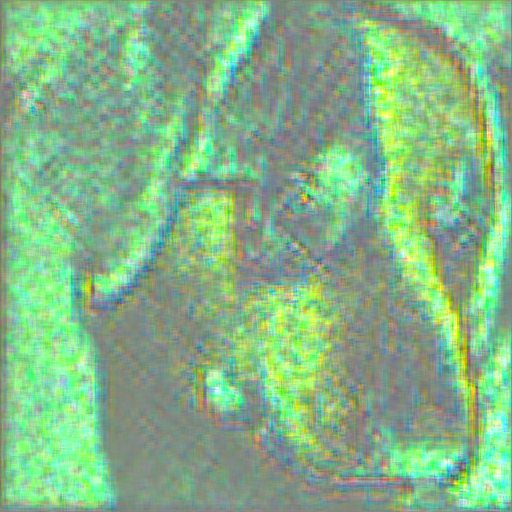

In [41]:
# Generate an image
prompt = "A photo of a dog"
image = pipe(prompt, num_inference_steps=50).images[0]
image